In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator
from tqdm import tqdm
# from floorplan_utils import *
# from img_utils import *

In [95]:
mpl.rcParams['figure.figsize'] = [15, 15]

# Graph processing

In [96]:
opt_df = pd.read_pickle('./opt_df.pic')

In [97]:
opt_df

,wf,gnss_lat,gnss_lon,z,z_raw,is_baro,t,x,y,pdr_vel,...,traj_id,gnss_easting,gnss_northing,theta,is_elevation,floor_id,elevation_height,max_dist,lat,lon
step_id,,,,,,,,,,,,,,,,,,,,,
1,"{'207394925875571': -47, '207394925875570': -4...",NaN,NaN,-0.003880,0.000000,True,5455892.0,19.429567,25.583819,0.69723,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942983,-3.188700
2,None,55.942823,-3.18914,-0.003880,0.000000,True,5455992.0,19.415120,25.540276,0.74234,...,0,-8.031963,7.682255,0,False,0.0,0.0,42.583348,55.942983,-3.188700
3,None,NaN,NaN,-0.003880,0.000000,True,5456252.0,19.310557,25.395203,0.84942,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942982,-3.188702
4,None,NaN,NaN,-0.003880,0.000000,True,5456482.0,19.195583,25.262586,0.93122,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942980,-3.188704
5,None,NaN,NaN,-0.003880,0.000000,True,5456692.0,19.073481,25.141082,0.99524,...,0,NaN,NaN,0,False,0.0,0.0,42.583348,55.942979,-3.188706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106334,"{'207394925917588': -83, '207394925917587': -8...",NaN,NaN,-0.011057,0.522397,True,11123112.0,16.343454,-5.394785,0.27198,...,193,NaN,NaN,0,False,0.0,0.0,10.426916,55.942705,-3.188749
106335,None,NaN,NaN,-0.011057,0.547007,True,11123832.0,16.132462,-5.426694,0.27993,...,193,NaN,NaN,0,False,0.0,0.0,10.426916,55.942705,-3.188753
106336,None,NaN,NaN,-0.011057,0.553463,True,11124532.0,15.920868,-5.465603,0.30507,...,193,NaN,NaN,0,False,0.0,0.0,10.426916,55.942704,-3.188756


In [98]:
opt_df['x'].min()

-14.336349469974367

In [99]:
opt_df['x'].max()

23.047132921048554

In [100]:
opt_df['y'].min()

-32.87111300736769

In [101]:
opt_df['y'].max()

29.7023697005688

In [102]:
opt_df['floor_id'].min()

0.0

In [103]:
opt_df['floor_id'].max()

0.0

In [104]:
floor = 0.0
x_min = -35
x_max = 35
y_min = -40
y_max = 35
resolution = 0.1# 0.1 # meters per pixel
# traj_pix = opt_df.copy()
traj_pix = pd.DataFrame()
traj_pix['x_img'] = ((opt_df[opt_df['floor_id']==floor]['x'] - x_min) // resolution).astype(int)
traj_pix['y_img'] = ((y_max - opt_df[opt_df['floor_id']==floor]['y']) // resolution).astype(int)
traj_pix = traj_pix.drop_duplicates(ignore_index=True)

100%|██████████| 49448/49448 [00:02<00:00, 18545.98it/s]


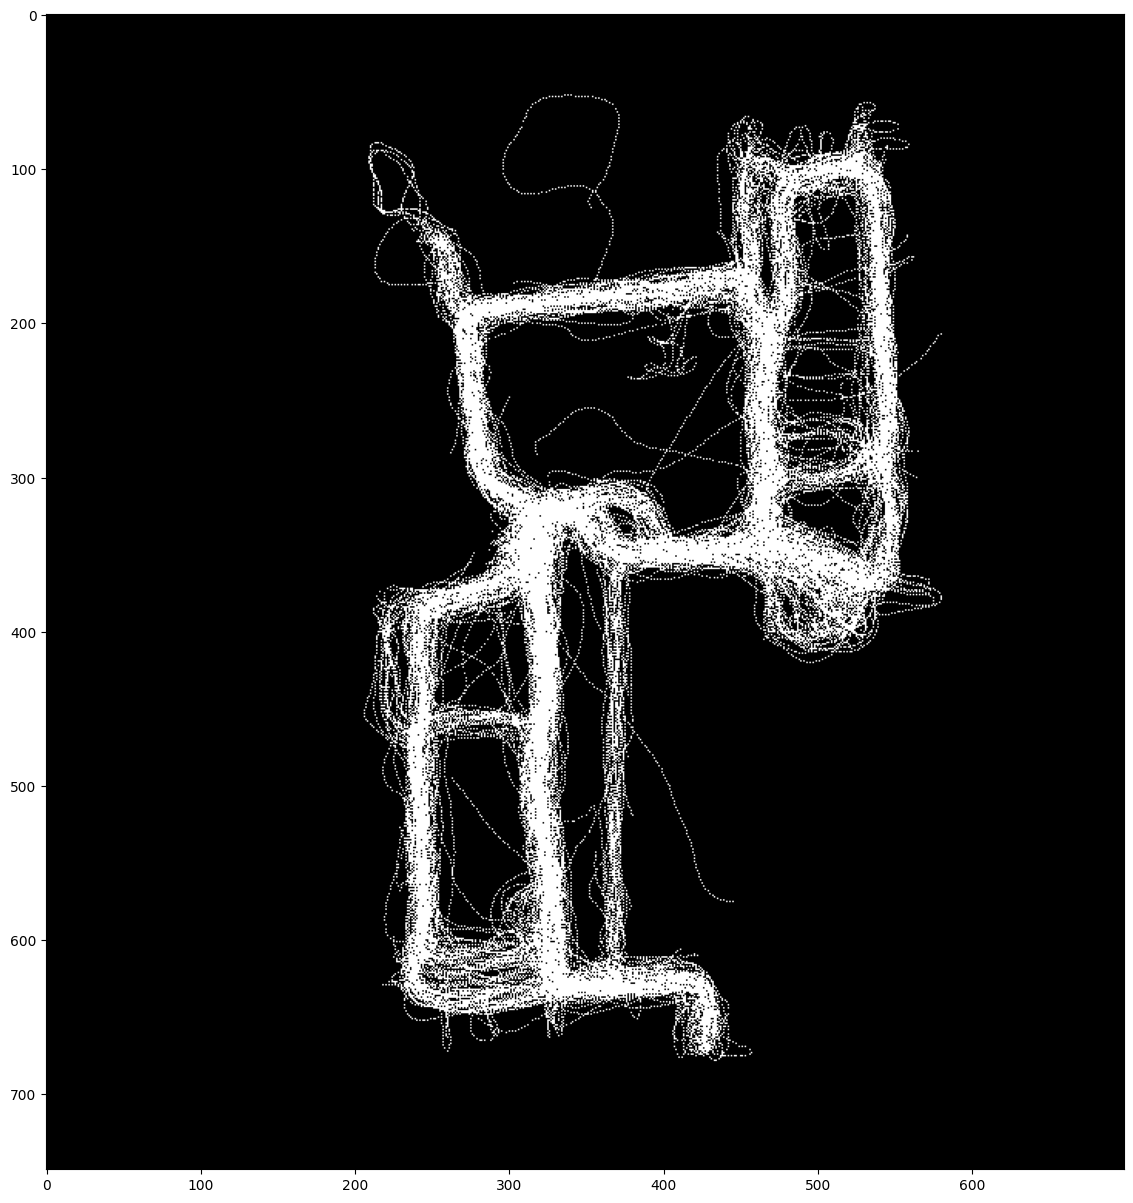

In [105]:
img_size_x = int((x_max - x_min) // resolution)
img_size_y = int((y_max - y_min) // resolution)
traj_img = np.zeros([img_size_y, img_size_x]).astype('uint8')
for i in tqdm(range(len(traj_pix))):
    traj_img[traj_pix.iloc[i,1], traj_pix.iloc[i,0]] = 255
plt.imshow(traj_img, cmap='gray')

In [106]:
traj_img.shape

(749, 699)

In [107]:
im = Image.fromarray(traj_img)
im.save('./radiomap_f1.png')

# Map processing

In [108]:
img_file = './2.png'
# pgw_file = r'C:\Users\p50023028\Documents\data\beijing_shoudu_t2\output\beijing_shoudu_t2_20220609_0302_0430\maps\2\2.pgw'

In [109]:
img = cv.imread(img_file, cv.IMREAD_GRAYSCALE)

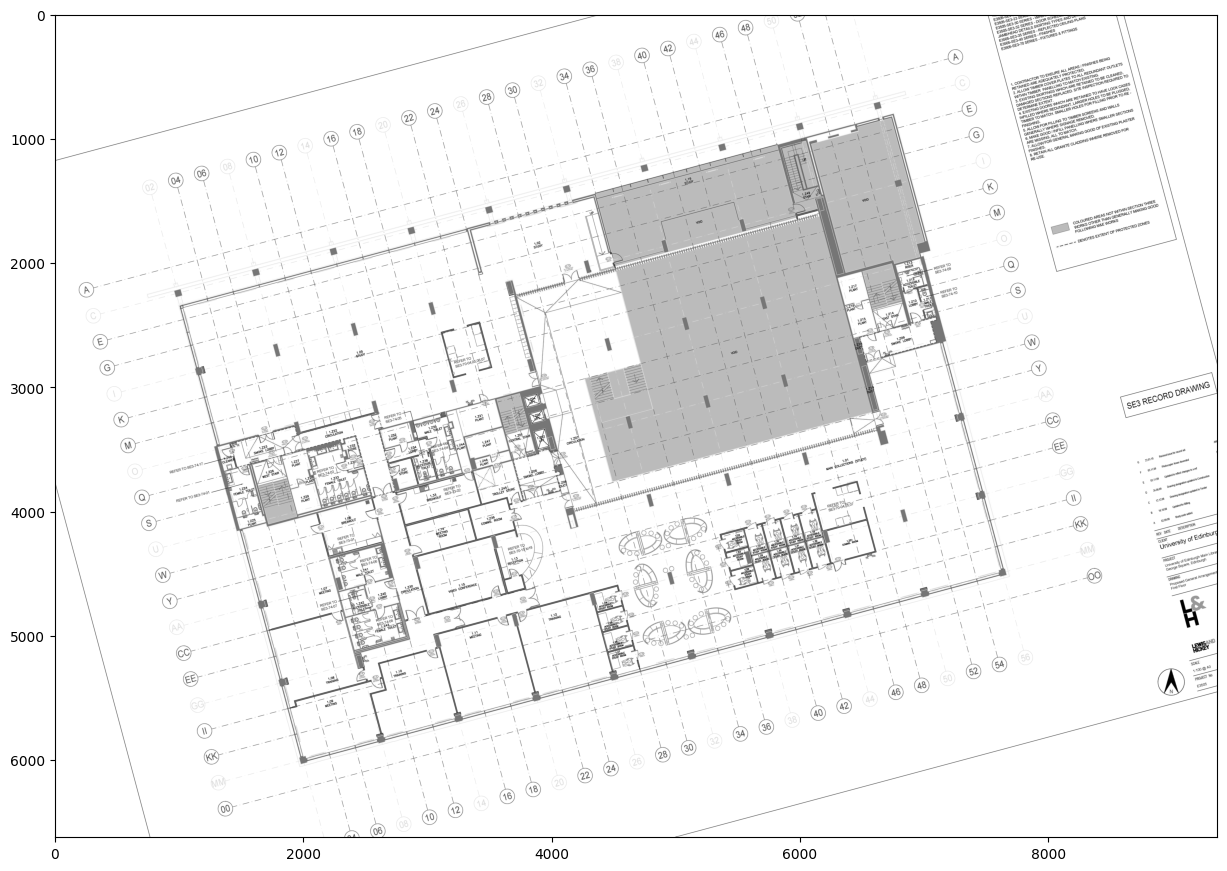

In [110]:
plt.imshow(img, cmap='gray')

In [111]:
img.shape

(6623, 9362)

In [112]:
# np.save('./bayes_radiomap/bayes_f1_map.npy', img)
np.save('./ml_map.npy', img)

# Load manually selected feature points

Read points and flip from (x, y) to (y, x)

In [113]:
# traj_gt = np.array([[337, 70],
#                     [238, 132],
#                     [276, 203],
#                     [443, 122],
#                     [556, 375],
#                     [458, 435],
# #                     [278, 600]
#                    ])
# map_gt = np.array([[588, 803],
#                    [661, 1122],
#                    [913, 1045],
#                    [770, 476],
#                    [1610, 260],
#                    [1767, 618],
# #                    [2170, 1533]
#                   ])
traj_gt = np.array(
    [
        [426.9,672.5],
        [418.8,627.1],
        [368.68,617.49],
        [255.5,143.2],
    ]
)
map_gt = np.array(
    [
        [7050,2549],
        [6591,2772],
        [6621,3248],
        [2552,5117],
    ]
)
traj_gt = np.flip(traj_gt, axis=1)
map_gt = np.flip(map_gt, axis=1)

In [114]:
print(map_gt.shape)
print(traj_gt.shape)

(4, 2)
(4, 2)


In [115]:
map_gt

array([[2549, 7050],
       [2772, 6591],
       [3248, 6621],
       [5117, 2552]])

In [116]:
traj_gt

array([[672.5 , 426.9 ],
       [627.1 , 418.8 ],
       [617.49, 368.68],
       [143.2 , 255.5 ]])

# Load images

```map_img``` and ```traj_img``` contains matching points (x, y) in IMAGE COORDINATES.

In [3]:
# map_img = np.load('./bayes_radiomap/bayes_f1_map.npy')
map_img = np.load("ml_map.npy")
# traj_img = np.load('forum_f0_traj.npy')

In [118]:
print(map_img.shape)
print(traj_img.shape)

(6623, 9362)
(749, 699)


# Interpolate

The ```grid``` is in (y, x) sequence, as in usual numpy definition.

In [119]:
WIDTH = 9362
HEIGHT = 6623
dim = (WIDTH, HEIGHT)

In [120]:
grid = np.mgrid[0:HEIGHT, 0:WIDTH]
grid_flat = grid.reshape(2, -1).T

Data point coordinates: ```map_gt```

Interpolation target values: ```traj_gt```

Data grid of map coordinates: ```grid_flat```

Resulting grid of interpolated trajectory coordinates: ```grid_z_rbf```

In [121]:
grid_z_rbf = RBFInterpolator(map_gt, traj_gt)(grid_flat)
grid_z_rbf_reshape = grid_z_rbf.reshape(HEIGHT, WIDTH, 2)

The resulting interpolation is in (y, x) sequence.

# Warp image

In [122]:
map_x = np.append([], [ar[:,1] for ar in grid_z_rbf_reshape]).reshape(HEIGHT, WIDTH)
map_y = np.append([], [ar[:,0] for ar in grid_z_rbf_reshape]).reshape(HEIGHT, WIDTH)
map_x_32 = map_x.astype('float32')
map_y_32 = map_y.astype('float32')

```remap()``` takes a vector field where each vector points to the pixel of the source image.

```map_x_32``` and ```map_y_32``` describes the vector field. They are in the same shape of the image, aka, HxW.

Or else, the vector field can also be described by a 3D HxWx2 shape array. 

The pixel values are stored in ```traj_img```. ```map_x_32``` and ```map_y_32``` tells the algorithm where to fetch the pixel value in ```traj_img``` in order to fill the warped image.

In [123]:
warped_image = cv.remap(traj_img, map_x_32, map_y_32, cv.INTER_CUBIC)

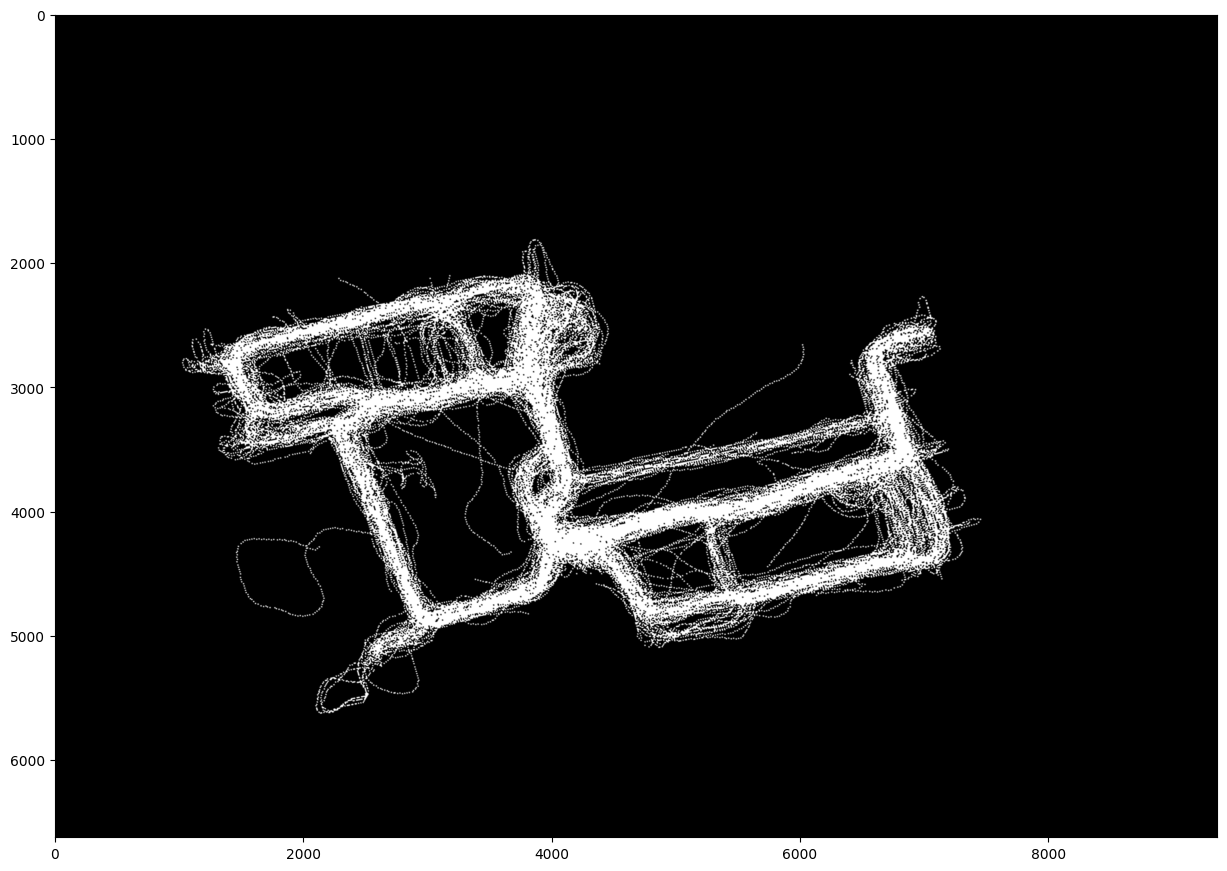

In [124]:
plt.imshow(warped_image, cmap='gray')

# Overlay images

In [125]:
warped_flip = (map_img - warped_image).astype('int')

In [126]:
viz = np.stack((map_img, warped_flip, warped_flip), axis=2)

In [127]:
map_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Text(0, 0.5, 'Y (North)')

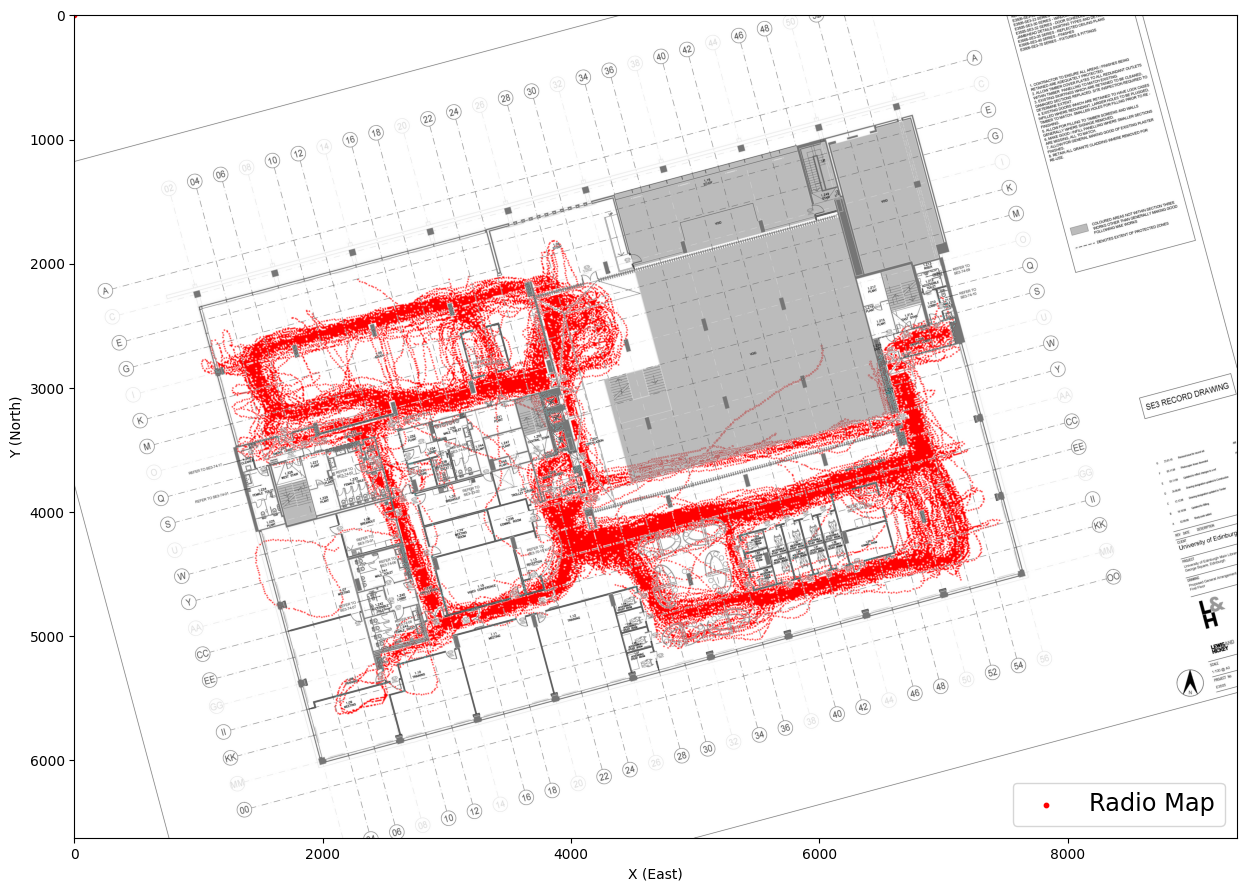

In [128]:
plt.imshow(viz)
plt.scatter(0, 0, label='Radio Map', c='r', s=10)
plt.legend(loc=4, fontsize='xx-large')
plt.xlabel('X (East)')
plt.ylabel('Y (North)')

# Apply to whole graph

In order to get the Lat Long value of the whole graph, the reverse of the above interpolation needs to be used:

Rather than mapping the graph to the floor plan, we need to map the floor plan to the graph.

In [129]:
floor = 0.0
x_min = -35
x_max = 35
y_min = -40
y_max = 35
resolution = 1.0 # meters per pixel
# traj_pix = opt_df.copy()
traj_pix = pd.DataFrame()
traj_pix['x_img'] = ((opt_df[opt_df['floor_id']==floor]['x'] - x_min) / resolution)
traj_pix['y_img'] = ((y_max - opt_df[opt_df['floor_id']==floor]['y']) / resolution)
traj_pix['wf'] = opt_df[opt_df['floor_id']==floor]['wf']
traj_pix['t'] = opt_df[opt_df['floor_id']==floor]['t']
traj_pix['orig_step_id'] = opt_df[opt_df['floor_id']==floor]['orig_step_id']
traj_pix['step_id'] = opt_df[opt_df['floor_id']==floor]['step_id']
traj_pix['traj_id'] = opt_df[opt_df['floor_id']==floor]['traj_id']
traj_pix['pdr_vel'] = opt_df[opt_df['floor_id']==floor]['pdr_vel']
traj_pix['pdr_head'] = opt_df[opt_df['floor_id']==floor]['pdr_head']
traj_pix['pdr_dist'] = opt_df[opt_df['floor_id']==floor]['pdr_dist']
traj_pix['pdr_still'] = opt_df[opt_df['floor_id']==floor]['pdr_still']
traj_pix['theta'] = opt_df[opt_df['floor_id']==floor]['theta']

In [130]:
# traj_pix = traj_pix.dropna()

In [131]:
traj_pix

,x_img,y_img,wf,t,orig_step_id,step_id,traj_id,pdr_vel,pdr_head,pdr_dist,pdr_still,theta
step_id,,,,,,,,,,,,
1,54.429567,9.416181,"{'207394925875571': -47, '207394925875570': -4...",5455892.0,52,1,0,0.69723,-40.24670,0.29775,False,0
2,54.415120,9.459724,None,5455992.0,62,2,0,0.74234,-45.32307,0.36997,False,0
3,54.310557,9.604797,None,5456252.0,88,3,0,0.84942,-59.94103,0.57777,False,0
4,54.195583,9.737414,None,5456482.0,111,4,0,0.93122,-76.65261,0.78318,False,0
5,54.073481,9.858918,None,5456692.0,132,5,0,0.99524,-98.87515,0.98596,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
106334,51.343454,40.394785,"{'207394925917588': -83, '207394925917587': -8...",11123112.0,11465,106334,193,0.27198,341.73926,43.82828,False,0
106335,51.132462,40.426694,None,11123832.0,11537,106335,193,0.27993,-358.01536,44.02808,False,0
106336,50.920868,40.465603,None,11124532.0,11607,106336,193,0.30507,-2622.52873,44.22974,False,0


In [132]:
# traj_gt = np.array([[337, 70],
#                     [238, 132],
#                     [276, 203],
#                     [443, 122],
#                     [556, 375],
#                     [458, 435],
# #                     [278, 600]
#                    ])
# map_gt = np.array([[588, 803],
#                    [661, 1122],
#                    [913, 1045],
#                    [770, 476],
#                    [1610, 260],
#                    [1767, 618],
# #                    [2170, 1533]
#                   ])

traj_gt = np.array(
    [
        [426.9,672.5],
        [418.8,627.1],
        [368.68,617.49],
        [255.5,143.2],
    ]
)
map_gt = np.array(
    [
        [7050,2549],
        [6591,2772],
        [6621,3248],
        [2552,5117],
    ]
)
traj_gt = np.flip(traj_gt, axis=1)
map_gt = np.flip(map_gt, axis=1)
# traj_gt = traj_gt / 10
# map_gt = map_gt  / 72 / 39.37 * 100
traj_gt = traj_gt 
map_gt = map_gt /200/39.37 * 100



```map_gt``` stores (y, x) in image coordinates, in meters.

```y``` needs to be the opposite for ENU coordinates.

In [133]:
map_gt_enu = map_gt.copy()
map_gt_enu[:, 0] = -map_gt_enu[:, 0] 

Translate to wgs

In [134]:
# map_gt_wgs = []
# for y, x in map_gt_enu:
#     wgs = enu_to_wgs(x, y, pgw)
#     map_gt_wgs.append(wgs)
# map_gt_wgs = np.array(map_gt_wgs)

Method 1: Interpolate map points based on graph grid.

In [135]:
# grid = np.mgrid[0:1000, 0:500]
# grid_flat = grid.reshape(2, -1).T
# grid_z = RBFInterpolator(traj_gt, map_gt_wgs)(grid_flat)

In [136]:
np.mgrid[0:70:0.1, 0:70]

array([[[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        ...,
        [69.7, 69.7, 69.7, ..., 69.7, 69.7, 69.7],
        [69.8, 69.8, 69.8, ..., 69.8, 69.8, 69.8],
        [69.9, 69.9, 69.9, ..., 69.9, 69.9, 69.9]],

       [[ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        ...,
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ],
        [ 0. ,  1. ,  2. , ..., 67. , 68. , 69. ]]])

In [137]:
grid = np.mgrid[0:70:0.1, 0:70:0.1]
grid_flat = grid.reshape(2, -1).T
grid_z = RBFInterpolator(traj_gt, map_gt_enu)(grid_flat)

In [138]:
def find_nearest(array, value):
    idx = (np.linalg.norm(array - value, axis=1)).argmin()
    return idx

In [139]:
graph_wgs = []
for i in tqdm(range(traj_pix.shape[0])):
    value = np.array([traj_pix['y_img'].iloc[i], traj_pix['x_img'].iloc[i]])
    idx = find_nearest(grid_flat, value)
    graph_wgs.append(grid_z[idx])
graph_wgs = np.array(graph_wgs)

100%|██████████| 101250/101250 [20:07<00:00, 83.85it/s]


In [140]:
traj_pix['x_meter'] = graph_wgs[:, 1].copy()
traj_pix['y_meter'] = graph_wgs[:, 0].copy()

In [141]:
traj_pix.to_pickle('./ml_f1_matched_radiomap_all.pic')

In [142]:
traj_pix

,x_img,y_img,wf,t,orig_step_id,step_id,traj_id,pdr_vel,pdr_head,pdr_dist,pdr_still,theta,x_meter,y_meter
step_id,,,,,,,,,,,,,,
1,54.429567,9.416181,"{'207394925875571': -47, '207394925875570': -4...",5455892.0,52,1,0,0.69723,-40.24670,0.29775,False,0,23.621315,-90.555292
2,54.415120,9.459724,None,5455992.0,62,2,0,0.74234,-45.32307,0.36997,False,0,23.633090,-90.552881
3,54.310557,9.604797,None,5456252.0,88,3,0,0.84942,-59.94103,0.57777,False,0,23.648255,-90.561661
4,54.195583,9.737414,None,5456482.0,111,4,0,0.93122,-76.65261,0.78318,False,0,23.663419,-90.570441
5,54.073481,9.858918,None,5456692.0,132,5,0,0.99524,-98.87515,0.98596,False,0,23.690359,-90.576811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106334,51.343454,40.394785,"{'207394925917588': -83, '207394925917587': -8...",11123112.0,11465,106334,193,0.27198,341.73926,43.82828,False,0,27.373433,-90.158248
106335,51.132462,40.426694,None,11123832.0,11537,106335,193,0.27993,-358.01536,44.02808,False,0,27.380216,-90.180627
106336,50.920868,40.465603,None,11124532.0,11607,106336,193,0.30507,-2622.52873,44.22974,False,0,27.398754,-90.200617


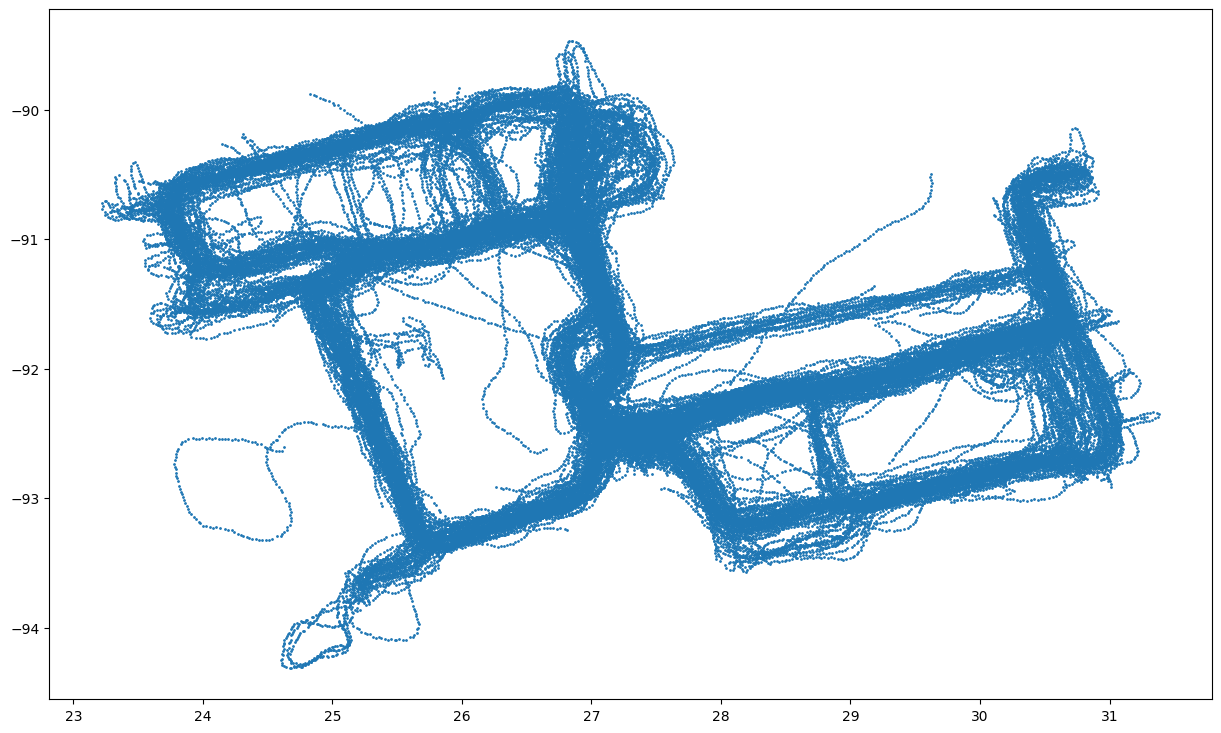

In [143]:
plt.scatter(traj_pix['x_meter'], traj_pix['y_meter'], s=1)
plt.gca().set_aspect('equal', adjustable='box')

In [144]:
warped_flip = (map_img - warped_image).astype('int')

In [145]:
traj_pix = pd.read_pickle("ml_f1_matched_radiomap_all.pic")
traj_pix

,x_img,y_img,wf,t,orig_step_id,step_id,traj_id,pdr_vel,pdr_head,pdr_dist,pdr_still,theta,x_meter,y_meter
step_id,,,,,,,,,,,,,,
1,54.429567,9.416181,"{'207394925875571': -47, '207394925875570': -4...",5455892.0,52,1,0,0.69723,-40.24670,0.29775,False,0,23.621315,-90.555292
2,54.415120,9.459724,None,5455992.0,62,2,0,0.74234,-45.32307,0.36997,False,0,23.633090,-90.552881
3,54.310557,9.604797,None,5456252.0,88,3,0,0.84942,-59.94103,0.57777,False,0,23.648255,-90.561661
4,54.195583,9.737414,None,5456482.0,111,4,0,0.93122,-76.65261,0.78318,False,0,23.663419,-90.570441
5,54.073481,9.858918,None,5456692.0,132,5,0,0.99524,-98.87515,0.98596,False,0,23.690359,-90.576811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106334,51.343454,40.394785,"{'207394925917588': -83, '207394925917587': -8...",11123112.0,11465,106334,193,0.27198,341.73926,43.82828,False,0,27.373433,-90.158248
106335,51.132462,40.426694,None,11123832.0,11537,106335,193,0.27993,-358.01536,44.02808,False,0,27.380216,-90.180627
106336,50.920868,40.465603,None,11124532.0,11607,106336,193,0.30507,-2622.52873,44.22974,False,0,27.398754,-90.200617


No handles with labels found to put in legend.


Text(0, 0.5, 'Y (North)')

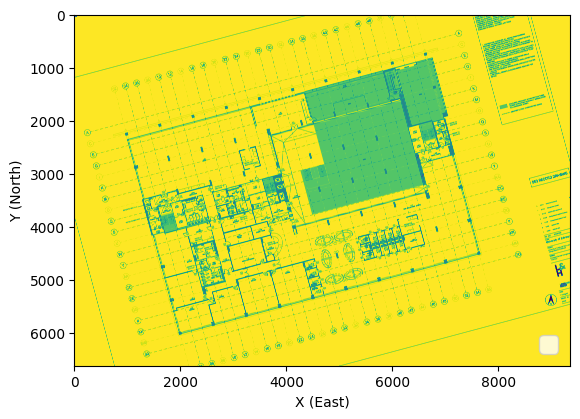

In [5]:
plt.imshow(map_img)
# plt.scatter(traj_pix['x_meter'] / 100 * 39.37 * 72, -traj_pix['y_meter'] / 100 * 39.37 * 72, s=1)
plt.scatter(traj_pix['x_meter'] /100/39.37 * 200, -traj_pix['y_meter'] /200/39.37 * 200, s=1)
# /200/39.37 * 100
# plt.scatter(traj_pix['x_img'] , -traj_pix['y_img'] , s=1)
plt.legend(loc=4, fontsize='xx-large')
plt.xlabel('X (East)')
plt.ylabel('Y (North)')

In [147]:
# opt_df = pd.read_pickle('./bayes_radiomap/bayes_f1_matched_radiomap.pic')

opt_df = pd.read_pickle('./ml_f1_matched_radiomap_all.pic')

In [148]:
opt_df

,x_img,y_img,wf,t,orig_step_id,step_id,traj_id,pdr_vel,pdr_head,pdr_dist,pdr_still,theta,x_meter,y_meter
step_id,,,,,,,,,,,,,,
1,54.429567,9.416181,"{'207394925875571': -47, '207394925875570': -4...",5455892.0,52,1,0,0.69723,-40.24670,0.29775,False,0,23.621315,-90.555292
2,54.415120,9.459724,None,5455992.0,62,2,0,0.74234,-45.32307,0.36997,False,0,23.633090,-90.552881
3,54.310557,9.604797,None,5456252.0,88,3,0,0.84942,-59.94103,0.57777,False,0,23.648255,-90.561661
4,54.195583,9.737414,None,5456482.0,111,4,0,0.93122,-76.65261,0.78318,False,0,23.663419,-90.570441
5,54.073481,9.858918,None,5456692.0,132,5,0,0.99524,-98.87515,0.98596,False,0,23.690359,-90.576811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106334,51.343454,40.394785,"{'207394925917588': -83, '207394925917587': -8...",11123112.0,11465,106334,193,0.27198,341.73926,43.82828,False,0,27.373433,-90.158248
106335,51.132462,40.426694,None,11123832.0,11537,106335,193,0.27993,-358.01536,44.02808,False,0,27.380216,-90.180627
106336,50.920868,40.465603,None,11124532.0,11607,106336,193,0.30507,-2622.52873,44.22974,False,0,27.398754,-90.200617


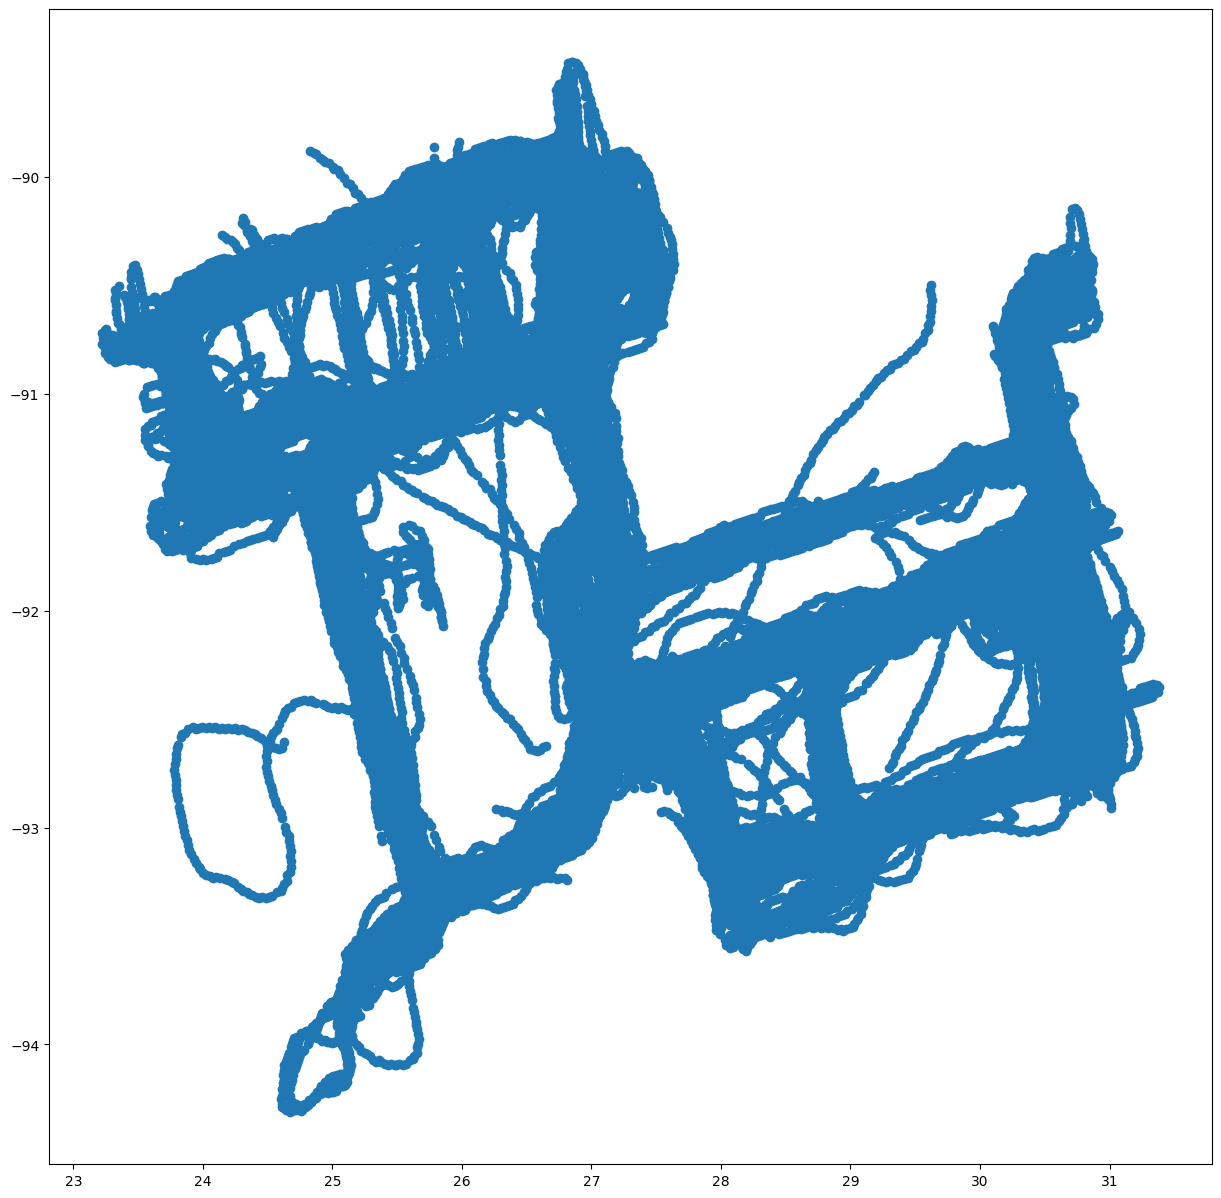

In [149]:
plt.scatter(opt_df.x_meter, opt_df.y_meter)

In [150]:
plt.scatter(opt_df.x_, opt_df.y_meter)

AttributeError: 'DataFrame' object has no attribute 'x_'